### Load Libraries

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Input,LSTM,Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-26 22:56:00.533363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Datasets

In [3]:
train_data = pd.read_csv('dataset/dataset/data_train.csv')
val_data = pd.read_csv('dataset/dataset/data_eval.csv')
val_data.head(10)

,question,answer,image_id
0,what is the colour of the bag on the chair,pink,image399
1,what is at the right bottom,table,image1341
2,what are found on the rack,toy,image1320
3,what is left of printer,mirror,image529
4,what is the colour of television,black,image201
5,what is on the dining table,ornamental_plant,image1439
6,what is the ball on the table,basketball,image477
7,how many drawers are there,4,image1362
8,what is on the left side of the sink,towel,image838
9,what is on the bed,"comforter, pillow",image73


### Read and plot image

(425, 560, 3)


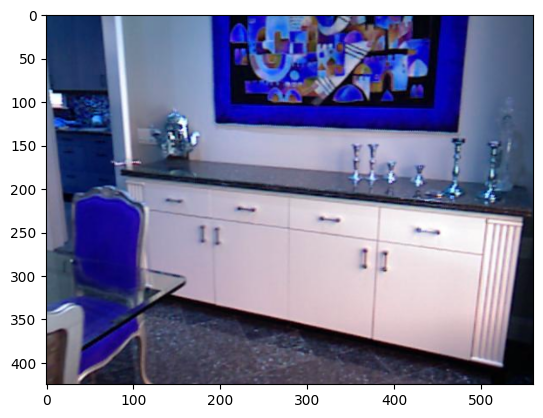

In [4]:
Image_dataset_path = 'dataset/dataset/images/'
image = Image_dataset_path + val_data.image_id[7] + '.png'
image_vect = cv2.imread(image)
print(image_vect.shape)
plt.imshow(image_vect)

### Tokenization

In [5]:
vocab_size = 10000
embedding_dim = 256
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [6]:
# Converting a specific Dataframe
# column to list using Series.tolist()
question_list_train = train_data["question"].tolist()
question_list_val = val_data["question"].tolist()
#tokenizer part
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(question_list_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(question_list_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(question_list_val)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Need this block to get it to work with TensorFlow 2.x

In [7]:

training_padded = np.array(training_padded)
#training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
#testing_labels = np.array(testing_labels)

### Prepare data

In [8]:
def preprocess(path,dataframe,mode=None):
    processed_data = []
    image_size = (224, 224) # new_size=(width, height)
    
    for i in tqdm(range(len(dataframe))):
        image = path + dataframe.image_id[i] + '.png'
        image_vect = cv2.imread(image)
        # resize the image
        resize_img = cv2.resize(image_vect, image_size)
        if mode == 'training':
            language_vect = training_padded
            processed_data.append([image_vect,language_vect])
        else:
            language_vect = testing_padded
            processed_data.append([image_vect,language_vect])
            
    return processed_data
Input_model = preprocess(Image_dataset_path,train_data,'training')

100%|██████████████████████████████████████| 9974/9974 [01:26<00:00, 114.92it/s]


In [32]:
### Save as npy of train input
np.save('train_Input_model.npy', np.array(Input_model, dtype=object), allow_pickle=True)

In [39]:
loaded_train_input = np.load('train_Input_model.npy', allow_pickle=True)

In [45]:
loaded_train_input[0][1]

array([[  3,   4,   2, ...,   0,   0,   0],
       [ 12, 217,  29, ...,   0,   0,   0],
       [  3,   4,  71, ...,   0,   0,   0],
       ...,
       [  3,   4,  23, ...,   0,   0,   0],
       [  3,   4,   2, ...,   0,   0,   0],
       [  3,   4,  30, ...,   0,   0,   0]], dtype=int32)

### Label encoding -- answer dataframe

In [21]:
# Count the number of unique values in the species column
output_neuron = train_data['answer'].nunique()

In [9]:
from sklearn.preprocessing import OneHotEncoder

train_answer_encoder = OneHotEncoder()
train_answer_encoded = train_answer_encoder.fit_transform(train_data[["answer"]])
pd.DataFrame(train_answer_encoded.toarray(), columns=train_answer_encoder.categories_).head()

,1,10,11,12,14,15,16,18,19,2,...,"yellow, blue, red","yellow, green","yellow, orange, black, purple","yellow, red","yellow, red, black","yellow, red, green, blue","yellow, red, orange","yellow, white",yoga_mat,"yoga_mat, basketball"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<center><img src="https://i.postimg.cc/vTBX9dV3/Screenshot-2023-07-25-at-12-53-01-AM.png" alt="Girl in a jacket" width="700" height="100"></center>

### Design Image model architecture

In [10]:
# A vision model.
# Encode an image into vector

vision_model = Sequential()
vision_model.add(Conv2D(64, (3,3),activation='relu',input_shape=(224,224,3)))
vision_model.add(MaxPooling2D())
vision_model.add(Flatten())

#Get a tensor with the output of vision model
image_input = Input(shape=(224,224,3))
encoded_image = vision_model(image_input)

### Design Language model architecture

In [11]:
# A Language model
# Emcode the question into a vector
question_input = Input(shape=(100,),dtype='int32',name='Question')
embedded = Embedding(input_dim=10000,output_dim=256,input_length=100)(question_input)
encoded_question = LSTM(256)(embedded)

In [ ]:
merged = layers.concatenate([encoded_image,encoded_question])
# Train a classifier on top
output = Dense(output_neuron,activation='softmax')(merged)
# you cam train with .fit ,.trin_on_batch
# you can train with GradienTape
vqa_model = Model(inputs=[image_input,question_input],outputs=output)

vqa_model.summary()

In [13]:
# compile 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vqa_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
vqa_model.fit(Input_model,train_answer_encoded,epochs=5)

ValueError: Dimensions 425 and 9974 are not compatible